<a href="https://colab.research.google.com/github/mehrnazeraeisi/Cookie_Recipes/blob/main/Cookie_Recipes_knnregression_modification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import train_test_split


In [3]:

# Function to prioritize features based on KNN R² score
def features_prioritization(X, y, features):
    features_scores = []
    knn_reg = KNeighborsRegressor()

    for feature in features:
        X_feature = X[[feature]]  # Ensure 2D
        knn_reg.fit(X_feature, y)
        r2 = knn_reg.score(X_feature, y)
        features_scores.append((feature, r2))

    df_scores = pd.DataFrame(features_scores, columns=['Feature', 'R2_Score']).sort_values(by='R2_Score', ascending=False)
    return df_scores


In [19]:
# بارگذاری فایل اکسل
data = pd.read_csv('cookie_recipes.csv')

print(data.columns)
# نمایش اطلاعات
print(data.head())
data.shape


Index(['flour', 'butter', 'eggs', 'soda', 'chips', 'rating'], dtype='object')
   flour  butter  eggs  soda  chips  rating
0   2.50       6     3     3   0.75    1.25
1   2.25      10     1     3   1.25    2.50
2   1.50      10     3     4   1.25    3.50
3   1.50      10     3     1   0.75    2.75
4   1.50      10     3     3   0.75    2.75


(50, 6)

In [20]:

# جدا کردن ویژگی‌ها و برچسب‌ها
X_data = data.drop('rating', axis=1)
y_data = data['rating']
data_features = X_data.columns       # نام ویژگی‌ها




In [22]:
# Run feature prioritization for the iris dataset
data_scores = features_prioritization(X_data, y_data, data_features)
print("🔎 Feature Group Performance Summary (cookie_recipes dataset):")
print(data_scores)  # Categorize features by R² score

🔎 Feature Group Performance Summary (cookie_recipes dataset):
  Feature  R2_Score
4   chips  0.563751
0   flour  0.512941
3    soda -0.018843
2    eggs -0.037246
1  butter -0.045898


In [23]:
# Categorizing features by R² score into multiple levels
strong_features = data_scores[data_scores['R2_Score'] > 0.5]['Feature'].tolist()
medium_features_1 = data_scores[(data_scores['R2_Score'] > -0.02)]['Feature'].tolist()
medium_features_2 = data_scores[(data_scores['R2_Score'] > -0.04)]['Feature'].tolist()
medium_features_3 = data_scores[(data_scores['R2_Score'] > -0.05)]['Feature'].tolist()


In [24]:
# Function to safely compute KNN R² score for feature group

def knn_score(X_data, y_data, selected_features):
    if len(selected_features) == 0:  # اصلاح این خط
        return np.nan
    model = KNeighborsRegressor()
    X_subset = X_data[selected_features]
    model.fit(X_subset, y_data)
    return model.score(X_subset, y_data)

In [25]:

#[8]
# Compute R² and accuracy scores for each group
groups = [data_features, strong_features, medium_features_1, medium_features_2, medium_features_3]

r2_scores = [knn_score(X_data, y_data, group) for group in groups]


In [27]:
# Build summary DataFrame
summary_df = pd.DataFrame({
    'Feature_Group': ['All Features', 'Strong Features', 'Medium Features_1 (0.7-0.8)', 'Medium Features_2 (0.6-0.7)',
                      'Medium Features_3 (0.5-0.6)'],
    'R2_Score': r2_scores
})

print("\n📊 Grouped Feature Performance Summary (R² and Accuracy):")
print(summary_df)



📊 Grouped Feature Performance Summary (R² and Accuracy):
                 Feature_Group  R2_Score
0                 All Features  0.450546
1              Strong Features  0.971479
2  Medium Features_1 (0.7-0.8)  0.903989
3  Medium Features_2 (0.6-0.7)  0.668781
4  Medium Features_3 (0.5-0.6)  0.450546


In [29]:

def knn_evaluation(X_data, y_data,strong_features , medium_features_1, medium_features_2, data_features, test_size, n_repeats):
    # Initialize lists to store the results

    r2_scores = {
        "All_features": [],
        "strong_features":[],
        "medium_features_1": [],
        "medium_features_2": [],
    }


    # List of feature groups to evaluate
    feature_groups = {
        "All_features": data_features,
        "strong_features": strong_features,
        "medium_features_1": medium_features_1,
        "medium_features_2":medium_features_2
    }

    # Repeat the process n_repeats times with different train-test splits
    for _ in range(n_repeats):
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

        for group_name, group_features in feature_groups.items():
            # KNN Regressor
            knn_reg = KNeighborsRegressor(n_neighbors=5)
            knn_reg.fit(X_train[group_features], y_train)
            y_pred_reg = knn_reg.predict(X_test[group_features])
            r2_scores[group_name].append(r2_score(y_test, y_pred_reg))

    # Plot results for R² and Accuracy
    x = np.arange(1, n_repeats + 1)


    # R² plot
    plt.figure( figsize=(12, 6))
    for group_name, r2_list in r2_scores.items():
        plt.plot(x, r2_list, label=f"{group_name.replace('_', ' ').title()} R²", marker='x')
    plt.xlabel('Repeat')
    plt.ylabel('R² Score')
    plt.title('KNN Regressor Performance')
    plt.legend()
    plt.show()



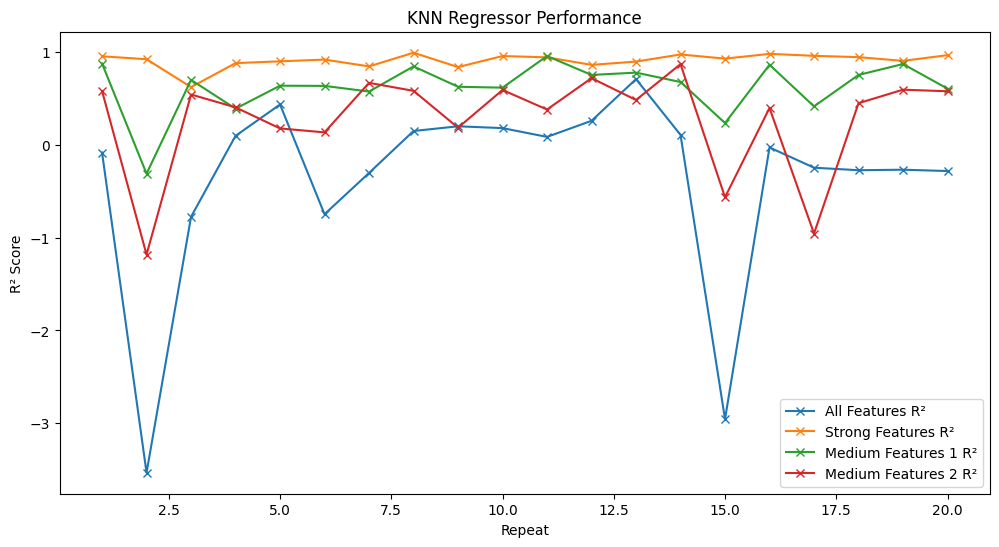

In [30]:

# Example usage (add this after you load and preprocess your data):
knn_evaluation(X_data, y_data, strong_features, medium_features_1, medium_features_2, data_features, test_size=0.1, n_repeats=20)


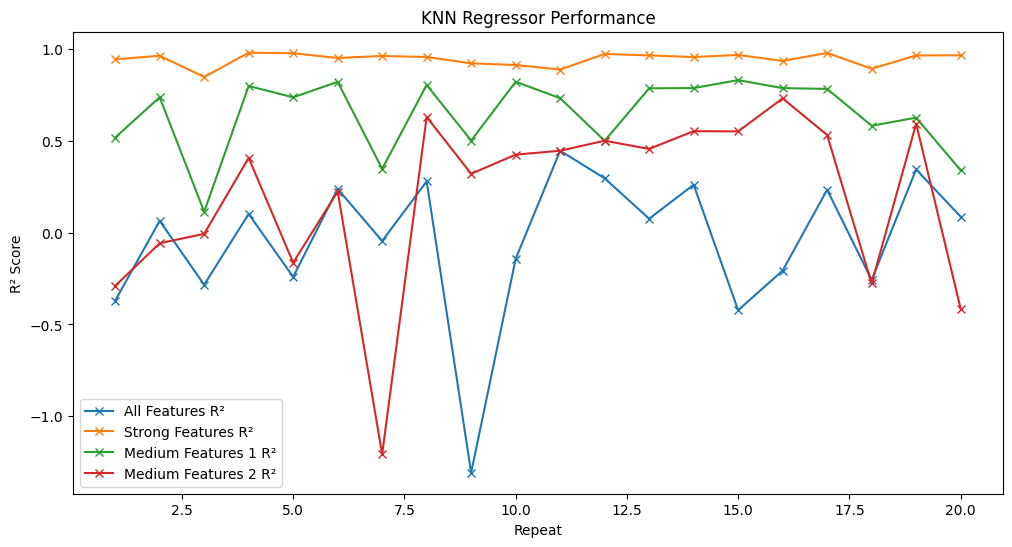

In [32]:

# Example usage (add this after you load and preprocess your data):
knn_evaluation(X_data, y_data, strong_features, medium_features_1, medium_features_2, data_features, test_size=0.13, n_repeats=20)


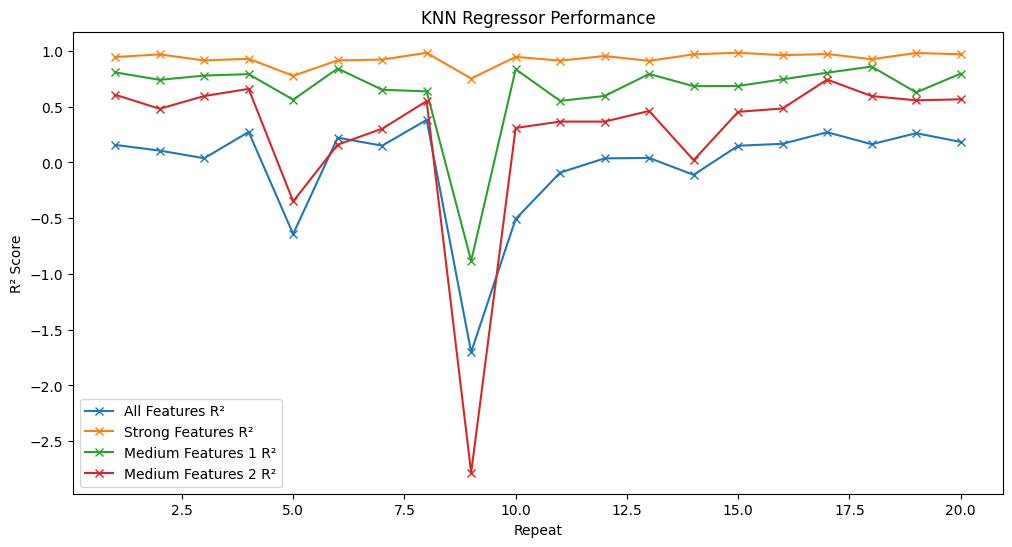

In [33]:

# Example usage (add this after you load and preprocess your data):
knn_evaluation(X_data, y_data, strong_features, medium_features_1, medium_features_2, data_features, test_size=0.16, n_repeats=20)


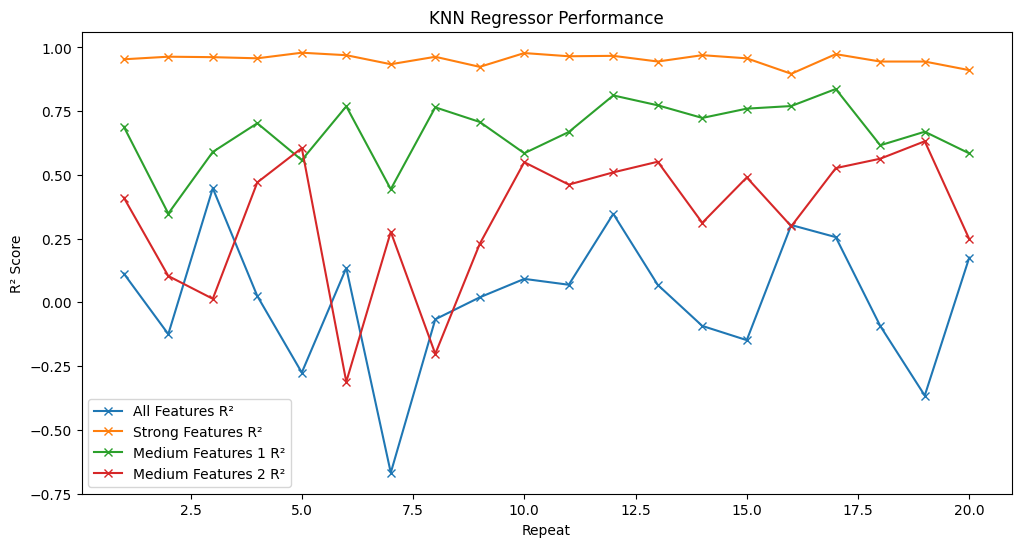

In [34]:

# Example usage (add this after you load and preprocess your data):
knn_evaluation(X_data, y_data, strong_features, medium_features_1, medium_features_2, data_features, test_size=0.19, n_repeats=20)


Index(['flour', 'butter', 'eggs', 'soda', 'chips', 'rating'], dtype='object')
   flour  butter  eggs  soda  chips  rating
0   2.50       6     3     3   0.75    1.25
1   2.25      10     1     3   1.25    2.50
2   1.50      10     3     4   1.25    3.50
3   1.50      10     3     1   0.75    2.75
4   1.50      10     3     3   0.75    2.75
🔎 Feature Group Performance Summary (cookie_recipes dataset):
  Feature  R2_Score
4   chips  0.563751
0   flour  0.512941
3    soda -0.018843
2    eggs -0.037246
1  butter -0.045898

📊 Grouped Feature Performance Summary (R² and Accuracy):
                 Feature_Group  R2_Score
0                 All Features  0.450546
1              Strong Features  0.971479
2  Medium Features_1 (0.7-0.8)  0.903989
3  Medium Features_2 (0.6-0.7)  0.668781
4  Medium Features_3 (0.5-0.6)  0.450546


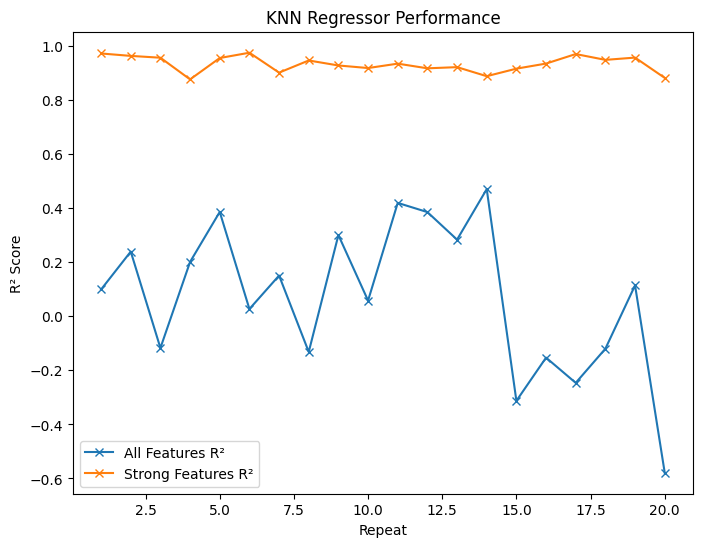

In [35]:
#[1]
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split



#[2]
# Function to prioritize features based on KNN R² score
def features_prioritization(X, y, features):
    features_scores = []
    knn_reg = KNeighborsRegressor()

    for feature in features:
        X_feature = X[[feature]]  # Ensure 2D
        knn_reg.fit(X_feature, y)
        r2 = knn_reg.score(X_feature, y)
        features_scores.append((feature, r2))

    df_scores = pd.DataFrame(features_scores, columns=['Feature', 'R2_Score']).sort_values(by='R2_Score', ascending=False)
    return df_scores



# بارگذاری فایل اکسل
data = pd.read_csv('cookie_recipes.csv')

print(data.columns)
# نمایش اطلاعات
print(data.head())
data.shape



# جدا کردن ویژگی‌ها و برچسب‌ها
X_data = data.drop('rating', axis=1)
y_data = data['rating']
data_features = X_data.columns       # نام ویژگی‌ها






#[5]
# Run feature prioritization for the iris dataset
data_scores = features_prioritization(X_data, y_data, data_features)
print("🔎 Feature Group Performance Summary (cookie_recipes dataset):")
print(data_scores)  # Categorize features by R² score

# Categorizing features by R² score into multiple levels
strong_features = data_scores[data_scores['R2_Score'] > 0.5]['Feature'].tolist()
medium_features_1 = data_scores[(data_scores['R2_Score'] > -0.02)]['Feature'].tolist()
medium_features_2 = data_scores[(data_scores['R2_Score'] > -0.04)]['Feature'].tolist()
medium_features_3 = data_scores[(data_scores['R2_Score'] > -0.05)]['Feature'].tolist()



#[7]
# Function to safely compute KNN R² score for feature group

def knn_score(X_data, y_data, selected_features):
    if len(selected_features) == 0:  # اصلاح این خط
        return np.nan
    model = KNeighborsRegressor()
    X_subset = X_data[selected_features]
    model.fit(X_subset, y_data)
    return model.score(X_subset, y_data)






#[8]
# Compute R² and accuracy scores for each group
groups = [data_features, strong_features, medium_features_1, medium_features_2, medium_features_3]

r2_scores = [knn_score(X_data, y_data, group) for group in groups]


# Build summary DataFrame
summary_df = pd.DataFrame({
    'Feature_Group': ['All Features', 'Strong Features', 'Medium Features_1 (0.7-0.8)', 'Medium Features_2 (0.6-0.7)',
                      'Medium Features_3 (0.5-0.6)'],
    'R2_Score': r2_scores
})

print("\n📊 Grouped Feature Performance Summary (R² and Accuracy):")
print(summary_df)




def knn_evaluation(X_data, y_data, strong_features, data_features, test_size, n_repeats):
    # Initialize lists to store the results

    r2_scores = {
        "all_features": [],
        "strong_features": [],
    }

    # List of feature groups to evaluate
    feature_groups = {
        "all_features": data_features,
        "strong_features": strong_features,
    }

    # Repeat the process n_repeats times with different train-test splits
    for _ in range(n_repeats):
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size)

        for group_name, group_features in feature_groups.items():
            # KNN Regressor
            knn_reg = KNeighborsRegressor(n_neighbors=5)
            knn_reg.fit(X_train[group_features], y_train)
            y_pred_reg = knn_reg.predict(X_test[group_features])
            r2_scores[group_name].append(r2_score(y_test, y_pred_reg))

    # Plot results for R² and Accuracy
    x = np.arange(1, n_repeats + 1)


    # R² plot
    plt.figure( figsize=(8, 6))
    for group_name, r2_list in r2_scores.items():
        plt.plot(x, r2_list, label=f"{group_name.replace('_', ' ').title()} R²", marker='x')
    plt.xlabel('Repeat')
    plt.ylabel('R² Score')
    plt.title('KNN Regressor Performance')
    plt.legend()
    plt.show()



# Example usage (add this after you load and preprocess your data):
knn_evaluation(X_data, y_data,  strong_features, data_features, test_size=0.19, n_repeats=20)
